In [1]:

#https://github.com/ekehoe32/orthrus
import sys
sys.path.append('/home/katrina/a/mankovic/ZOETIS/Fall2021/Orthrus/orthrus')
import orthrus
from orthrus import core
from orthrus.core import dataset
import numpy as np
import graph_tools_construction as gt
from matplotlib import pyplot as plt
import pandas
from orthrus.core.pipeline import *
from sklearn.preprocessing import FunctionTransformer
from orthrus.preprocessing.imputation import HalfMinimum
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA


dataroot = '/data4/mankovic/'

compare = 'pcor'


out_file_name = '/home/katrina/a/mankovic/ZOETIS/Fall2021/denovo_pathways/1-2022/Z42_'+str(compare)+'.csv'

In [2]:
#load Kartikay's gene feature set and store RandIDs for genes
Z42_features = pandas.read_csv('/data4/mankovic/De-Identified_CZ/z42_features_after_hyperparameter_search.csv', index_col = 0)
randIDs = [str(r) for r in list(Z42_features.index)]

#load the entire C1 and Z40 dataset and select the C1 data and metadata
ds = dataset.load_dataset(dataroot+'De-Identified_CZ/DeId_TPM_C1_Z40_Z34_Z42.ds')

In [3]:
network_data =  'both' #options are 'both'
# sample_ids = (ds.metadata['Project'] == 'Z42') & (ds.metadata['Time'] != -21) & (ds.metadata['Treatment'] == 'Treated')
# sample_ids = (ds.metadata['Project'] == 'Z42') & (ds.metadata['Time'] != -21) & (ds.metadata['Treatment'] == 'Challenge Only')
sample_ids = (ds.metadata['Project'] == 'Z42') & (ds.metadata['Time'] != -21)


Z42_dataset = ds.slice_dataset(sample_ids = sample_ids)



In [4]:
Z42_dataset = Z42_dataset.slice_dataset(feature_ids = randIDs)


In [5]:
#normalize the dataset
transform = make_pipeline(HalfMinimum(missing_values=0), FunctionTransformer(np.log2))
Z42_dataset.normalize(transform, norm_name='HalfMinimum + Log2')

Z42_data = Z42_dataset.data

all_randids = list(Z42_data.columns)

21 healthy and 24 sick


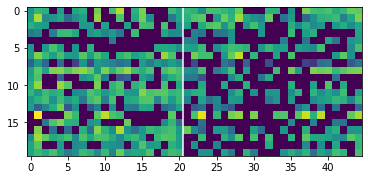

In [6]:
#sick healthy sorted X
if network_data == 'both':
    treated_seqID = list(Z42_dataset.metadata.query("Treatment == 'Treated'").index)
    challenged_seqID = list(Z42_dataset.metadata.query("Treatment == 'Challenge Only'").index)
    print(str(len(treated_seqID))+' healthy and ' +str(len(challenged_seqID))+' sick')
    sorted_X = np.vstack([np.array(Z42_data.loc[treated_seqID]), np.array(Z42_data.loc[challenged_seqID])])
    plt.imshow(sorted_X[:,:20].T)
    plt.axvline(len(treated_seqID)-.5,  color = 'white')
    plt.show()
    seqID_labels = len(treated_seqID)*['Treated']+len(challenged_seqID)*['Challenge Only']
else:
    sorted_X = np.array(Z42_data)

In [7]:
#generate adjacency matrix
similarity = 'correlation'

a = gt.adjacency_matrix(np.array(Z42_data.loc[treated_seqID][randIDs]), similarity, negative = True)
b = gt.adjacency_matrix(np.array(Z42_data.loc[challenged_seqID][randIDs]), similarity, negative = True)

if compare == 'difference':
    A = np.abs(b-a)
if compare == 'squared_diff':
    A = (b-a)**2
elif compare == 'ratio':
    print('this will not work with zeros in treated')
    A = np.abs(b)/(np.abs(a))
    # A[idx_less] = A_challenge[idx_less]/A_treated[idx_less]
    # A = A/np.max(A)
elif compare == 'pcor':
    #calc partial correlation

    A = np.zeros(a.shape)


    z_a = np.hstack([np.ones(len(treated_seqID)),np.ones(len(challenged_seqID))])
    nza = np.linalg.norm(z_a)

    for i in range(a.shape[0]):
        for j in range(i,a.shape[0]):

            x= sorted_X[:,i]
            y = sorted_X[:,j]
            
            nx = np.linalg.norm(x)
            ny = np.linalg.norm(y)

            r_xy = np.dot(x, y)/(nx*ny)
            r_zax = np.dot(x, z_a)/(nx*nza)
            r_zay = np.dot(z_a, y)/(nza*ny)


            pcor_a = (r_xy - r_zax*r_zay)/(np.sqrt(1-r_zax)*np.sqrt(1-r_zay))

            A[i,j] = pcor_a
            A[j,i] = pcor_a
            if i==j:
                A[j,i] = 0
    A = np.abs(A)
elif compare == 'zobs':
    #calc zobs
    n_treated = len(treated_seqID)
    n_challenged = len(challenged_seqID)

    zobs = np.nan_to_num((np.arctanh(a)-np.arctanh(b)) / np.sqrt( 1/(n_treated-3) + 1/(n_challenged-3)),0)

    A = np.abs(((np.abs(a) + np.abs(b)) * zobs) / 2)
elif compare == 'vol':
    n_treated = len(treated_seqID)
    n_challenged = len(challenged_seqID)

    A = np.abs(np.nan_to_num((np.arctanh(a)-np.arctanh(b)) / np.sqrt( 1/(n_treated-3) + 1/(n_challenged-3)),0))
elif compare == 'treated':
    A = np.abs(a)
elif compare == 'challenged': 
    A = np.abs(b)
else: 
    A =  gt.adjacency_matrix(np.array(sorted_X), similarity)

#whether or not we'll use normalized graph laplacian
not_normalized_laplacian = False

m = A.shape[0]

# #calculate the laplacian
# incident_edges = np.sum(A,axis = 1)
# #degree matrix
# D = np.diag(incident_edges)*np.eye(m)
# L = D-A


# #calculate the normalized laplacian
# snD = np.diag(1/np.sqrt(incident_edges))*np.eye(m)
# Ln = snD @ (D-A) @ snD


# #plots
# plt.figure()
# plt.imshow(A)
# plt.title('Correlation')

# plt.figure('A')
# plt.title('Sorted Adjacency Matrix Entries')
# plt.plot(np.sort(A.flatten()))

# plt.figure('L')
# plt.title('Laplacian Eigenvalues')
# plt.plot(np.linalg.eigh(L)[0])

# plt.figure('Ln')
# plt.title('Normalized Laplacian Eigenvalues')
# plt.plot(np.linalg.eigh(Ln)[0])




hi
303 562


Text(0, 0.5, 'Cluster Sizes')

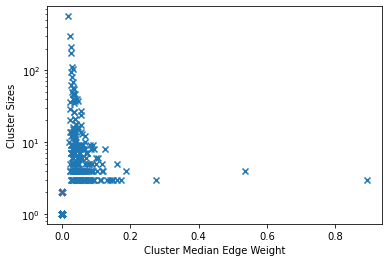

In [8]:
#higherarchical bi-partitioning




nodes = np.arange(m)


clst_adj_cor = []
clst_node_cor = []
all_clusters_node_cor = []

gt.cluster_laplace(A, clst_adj_cor, nodes, 1, clst_node_cor, all_clusters_node_cor, fiedler_switch =not_normalized_laplacian, stop_criteria = 'weight')
print('hi')

count = 0
for c in all_clusters_node_cor:
    if len(c)==1:
        count +=1
print(count, m)


#this gives number of nodes in highest median correlation cluster
n_clusters = len(all_clusters_node_cor)
cluster_scores = np.zeros(n_clusters)
cluster_sizes = np.zeros(n_clusters)
for ii in range(n_clusters):
    cluster = all_clusters_node_cor[ii]
    n_nodes = len(cluster)
    cluster_sizes[ii] = n_nodes
    if n_nodes > 2:
        weights = []
        for i in range(n_nodes):
            for j in range(i+1, n_nodes,1):
                weights.append(A[cluster[i],cluster[j]])
        cluster_scores[ii] = np.median(weights)

len(all_clusters_node_cor[np.argmax(cluster_scores)])

plt.scatter(cluster_scores, cluster_sizes, marker = 'x')
plt.yscale('log')
plt.xlabel('Cluster Median Edge Weight')
plt.ylabel('Cluster Sizes')


In [9]:
#set minimum module size and edge weight
min_module_size = 1
idx_sizes = np.where(cluster_sizes > min_module_size)[0]

thresh_cors = np.linspace(np.median(cluster_scores), np.max(cluster_scores), 100)
for thresh_cor in thresh_cors:
    idx_scores = np.where(cluster_scores > thresh_cor)[0]
    idx = list(set(idx_scores).intersection(set(idx_sizes)))
    if len(idx) <= 30:
        best_idx = idx
        best_thresh = thresh_cor
        break
print('cluster_sizes:')
print([cluster_sizes[i] for i in best_idx])

modules = []
for i in best_idx:
    modules.append([[randIDs[j] for j in all_clusters_node_cor[i]], list(all_clusters_node_cor[i])])
print('')
print('cluster elements:')
modules

cluster_sizes:
[3.0, 3.0, 3.0, 5.0, 3.0, 8.0, 6.0, 4.0, 3.0, 3.0, 4.0, 3.0, 6.0, 5.0, 3.0, 3.0, 9.0, 8.0, 5.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0]

cluster elements:


[[['21606', '25000', '4979'], [193, 253, 469]],
 [['22885', '2612', '6132'], [217, 278, 495]],
 [['25681', '28046', '35305'], [268, 308, 445]],
 [['13726', '23012', '25308', '33860', '6765'], [51, 219, 259, 418, 504]],
 [['13726', '33860', '6765'], [51, 418, 504]],
 [['1511', '16633', '23917', '2409', '28181', '31437', '7377', '8917'],
  [77, 105, 233, 236, 309, 376, 517, 544]],
 [['1511', '2409', '28181', '31437', '7377', '8917'],
  [77, 236, 309, 376, 517, 544]],
 [['20182', '21312', '22203', '31299'], [166, 187, 202, 371]],
 [['20182', '21312', '31299'], [166, 187, 371]],
 [['16601', '25064', '26685'], [104, 254, 291]],
 [['1511', '28181', '31437', '7377'], [77, 309, 376, 517]],
 [['1511', '28181', '7377'], [77, 309, 517]],
 [['23901', '27530', '29973', '31614', '5643', '7197'],
  [232, 301, 343, 380, 486, 511]],
 [['23901', '29973', '31614', '5643', '7197'], [232, 343, 380, 486, 511]],
 [['23901', '5643', '7197'], [232, 486, 511]],
 [['18624', '28214', '4002'], [144, 311, 457]],
 [

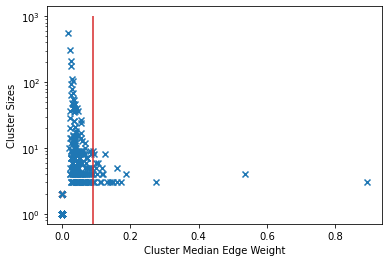

In [10]:
plt.scatter(cluster_scores, cluster_sizes, marker = 'x')
plt.yscale('log')
plt.xlabel('Cluster Median Edge Weight')
plt.ylabel('Cluster Sizes')
plt.vlines(best_thresh, 0, 1000, color = 'tab:red')


In [11]:
#get smallest subset with highest median weights
small_modules = []
for module in modules:
    subset = False
    for check_module in modules:
        #flip around to get biggest
        if set(check_module[0]).issubset(set(module[0])) and module[0] != check_module[0]:
            subset = True
    if not subset:
        small_modules.append(module)
small_modules

[[['21606', '25000', '4979'], [193, 253, 469]],
 [['22885', '2612', '6132'], [217, 278, 495]],
 [['25681', '28046', '35305'], [268, 308, 445]],
 [['13726', '33860', '6765'], [51, 418, 504]],
 [['20182', '21312', '31299'], [166, 187, 371]],
 [['16601', '25064', '26685'], [104, 254, 291]],
 [['1511', '28181', '7377'], [77, 309, 517]],
 [['23901', '5643', '7197'], [232, 486, 511]],
 [['18624', '28214', '4002'], [144, 311, 457]],
 [['17931', '33772', '7451'], [124, 416, 520]],
 [['33325', '5502', '8859'], [408, 482, 542]],
 [['186', '34146', '6965'], [142, 424, 510]],
 [['14723', '22666', '2499', '25752'], [69, 213, 251, 270]],
 [['19991', '30127', '33789'], [163, 346, 417]]]

In [12]:
#get smallest subset with highest median weights
big_modules = []
for module in modules:
    subset = False
    for check_module in modules:
        #flip around to get biggest
        if set(module[0]).issubset(set(check_module[0])) and module[0] != check_module[0]:
            subset = True
    if not subset:
        big_modules.append(module)
big_modules

[[['21606', '25000', '4979'], [193, 253, 469]],
 [['22885', '2612', '6132'], [217, 278, 495]],
 [['25681', '28046', '35305'], [268, 308, 445]],
 [['13726', '23012', '25308', '33860', '6765'], [51, 219, 259, 418, 504]],
 [['1511', '16633', '23917', '2409', '28181', '31437', '7377', '8917'],
  [77, 105, 233, 236, 309, 376, 517, 544]],
 [['20182', '21312', '22203', '31299'], [166, 187, 202, 371]],
 [['16601', '25064', '26685'], [104, 254, 291]],
 [['23901', '27530', '29973', '31614', '5643', '7197'],
  [232, 301, 343, 380, 486, 511]],
 [['18624', '28214', '4002'], [144, 311, 457]],
 [['17931',
   '19139',
   '21959',
   '25449',
   '28201',
   '32147',
   '33772',
   '35235',
   '7451'],
  [124, 151, 199, 264, 310, 391, 416, 444, 520]],
 [['18476', '33325', '5502', '8859'], [138, 408, 482, 542]],
 [['186', '34146', '6965'], [142, 424, 510]],
 [['14723', '22666', '2499', '25752'], [69, 213, 251, 270]],
 [['15340', '19991', '30127', '33789'], [85, 163, 346, 417]]]

In [13]:
denovo_pathway_df = pandas.DataFrame(columns = all_randids)

count = 0
for sm in small_modules:
    sm_ind = 'small_'+str(count)
    row = pandas.DataFrame(1, index = [sm_ind], columns = sm[0])
    denovo_pathway_df = denovo_pathway_df.append(row)
    count +=1

count = 0
for b in small_modules:
    b_ind = 'big_'+str(count)
    row = pandas.DataFrame(1, index = [b_ind], columns = b[0])
    denovo_pathway_df = denovo_pathway_df.append(row)
    count +=1


In [14]:
#save the denovo_pathway_df here
denovo_pathway_df.to_csv(out_file_name)

# More Stuff

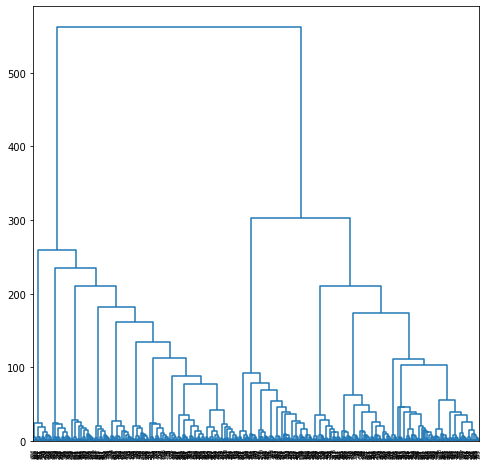

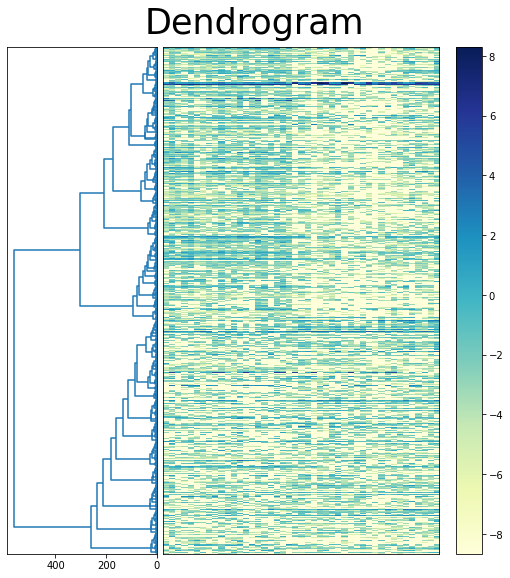

In [14]:
not_normalized_laplacian = False

nodes = np.arange(m)


clst_adj_cor = []
clst_node_cor = []
all_clusters_node_cor = []

gt.cluster_laplace(A, clst_adj_cor, nodes, 1, clst_node_cor, all_clusters_node_cor, fiedler_switch =not_normalized_laplacian, stop_criteria = 'size')

#plot dendrograms

for jd in [True, False]:
    gt.plot_dendrogram(all_clusters_node_cor, A, sorted_X, clst_dst = 'dumb', fname = 'delete_me.png', title='Dendrogram', just_dendrogram = jd, split = len(treated_seqID))

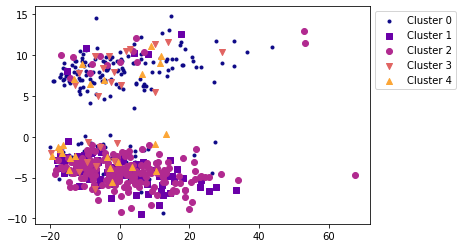

In [15]:

#calculate linkage matrix
Z_cor = gt.linkage_matrix(all_clusters_node_cor, A, 'dumb')


#plot some of the most distinct clusters
number_clusters = 5

labels = gt.cut_tree(Z_cor, n_clusters = number_clusters)
pca = PCA(n_components = 2)
embedding = pca.fit_transform(sorted_X.T)

markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_"]

color_list = plt.get_cmap('plasma').colors

n_colors = len(color_list)

c_sampler = [i*(n_colors//number_clusters) for i in range(number_clusters)]



for i in range(0,number_clusters,1):
    idx = np.where(labels == i)[0]
    # plt.scatter(embedding[idx,0],embedding[idx,1], color = colors[i % 5], marker = markers[i % 5], label = 'Cluster '+str(i))
    plt.scatter(embedding[idx,0],embedding[idx,1], color = color_list[c_sampler[i]], marker = markers[i], label = 'Cluster '+str(i))

plt.legend(loc="upper left", bbox_to_anchor=(1,1))





In [16]:
denovo_pathways = pandas.DataFrame(columns = randIDs, data = np.zeros((11, len(randIDs))))
for i in range(number_clusters):
    idx = np.where(labels == i)[0]
    for j in idx:
        denovo_pathways.iloc[i][randIDs[j]] = 1


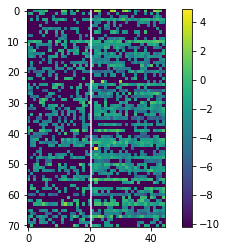

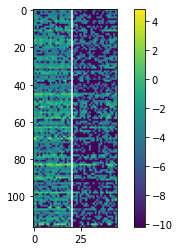

In [11]:
#cluster number 3
for i in range(number_clusters):
    plt.figure()
    idx = np.where(labels == i)[0]
    plt.imshow(sorted_X[:,idx].T)
    plt.axvline(len(treated_seqID)-.5, color = 'white')
    plt.colorbar()

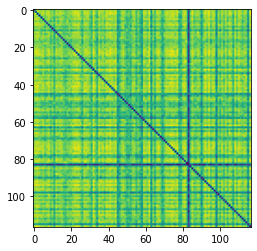

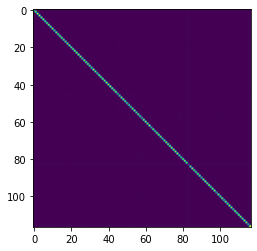

In [12]:
the_cluster = np.where(labels == 1)[0]
n_nodes = len(the_cluster)
small_A = np.zeros((n_nodes,n_nodes))
for i in range(n_nodes):
    for j in range(n_nodes):
        small_A[i,j] = A[the_cluster[i],the_cluster[j]]

plt.figure()
plt.imshow(small_A)

plt.figure()
D = np.diag(np.sum(small_A,axis=1))
plt.imshow(D-small_A)



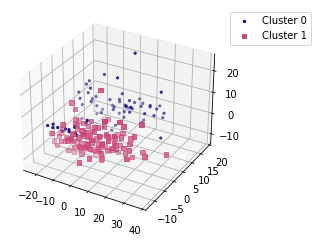

In [13]:
# %matplotlib notebook

#plot some of the most distinct clusters
number_clusters = 2

labels = gt.cut_tree(Z_cor, n_clusters =number_clusters)
pca = PCA(n_components = 3)
embedding = pca.fit_transform(sorted_X.T)

markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_"]

color_list = plt.get_cmap('plasma').colors

n_colors = len(color_list)

c_sampler = [i*(n_colors//number_clusters) for i in range(number_clusters)]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(0,number_clusters,1):
    idx = np.where(labels == i)[0]
    # plt.scatter(embedding[idx,0],embedding[idx,1], color = colors[i % 5], marker = markers[i % 5], label = 'Cluster '+str(i))
    ax.scatter(embedding[idx,0],embedding[idx,1],embedding[idx,2], color = color_list[c_sampler[i]], marker = markers[i], label = 'Cluster '+str(i))

plt.legend(loc="upper left", bbox_to_anchor=(1,1))


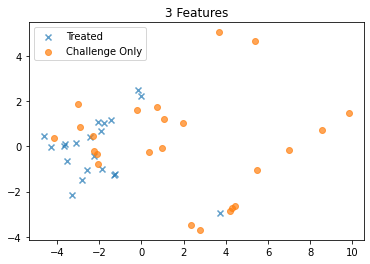

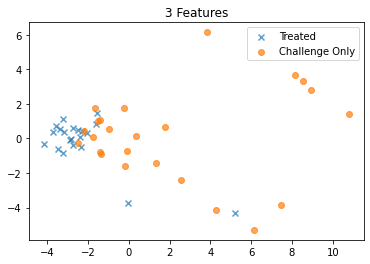

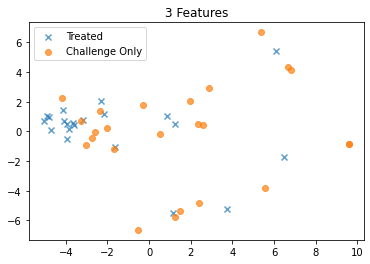

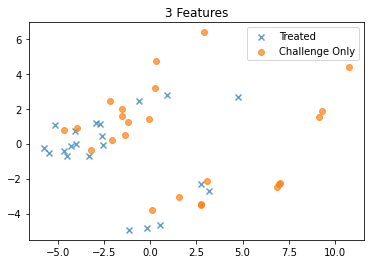

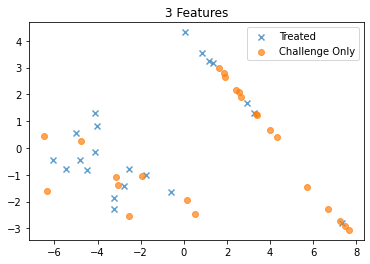

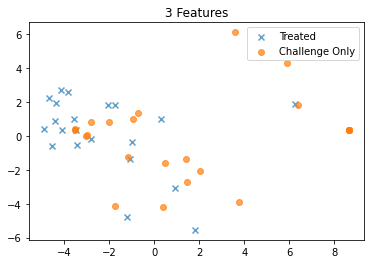

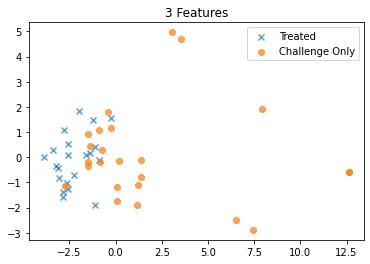

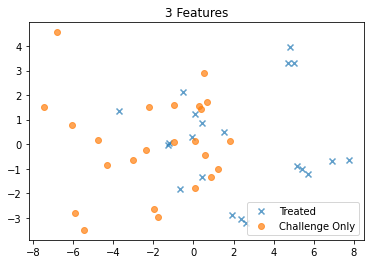

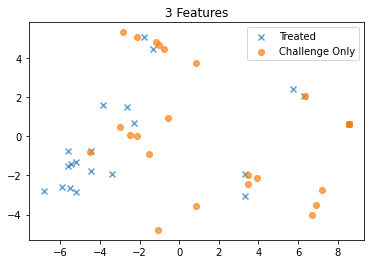

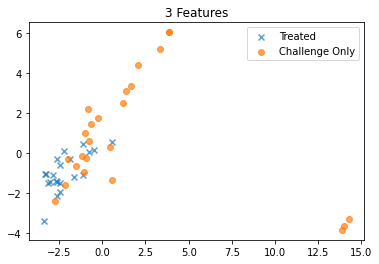

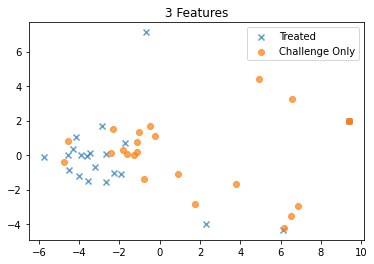

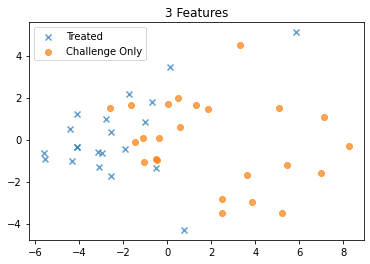

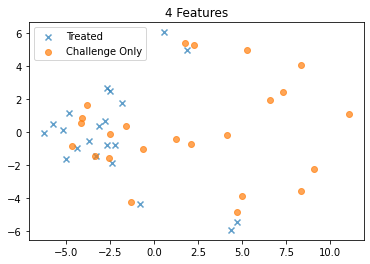

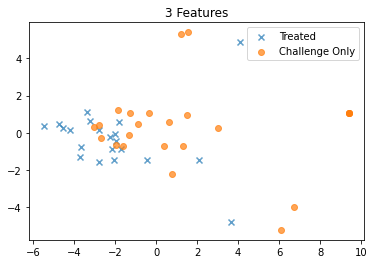

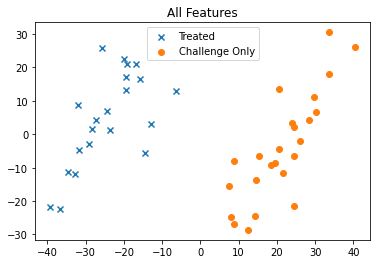

In [19]:
#PCA of subjects using genes in cluster number 1

# idx = np.where(labels == 1)[0]

filtered_modules = small_modules

for ii in range(len(filtered_modules)):
    idx = filtered_modules[ii][1]
    pca = PCA(n_components = 2)
    embedding = pca.fit_transform(sorted_X[:,idx])

    plt.figure()
    idx_none = np.where(np.array(seqID_labels) == 'Treated')
    idx_high = np.where(np.array(seqID_labels) == 'Challenge Only')
    plt.scatter(embedding[idx_none,0], embedding[idx_none,1], label = 'Treated', marker = 'x', alpha = .7)
    plt.scatter(embedding[idx_high,0], embedding[idx_high,1], label = 'Challenge Only', marker = 'o', alpha = .7)
    plt.title(str(len(idx))+ ' Features')
    plt.legend()

pca = PCA(n_components = 2)
embedding = pca.fit_transform(sorted_X)

plt.figure()
plt.title('All Features')
plt.scatter(embedding[idx_none,0], embedding[idx_none,1], label = 'Treated', marker = 'x')
plt.scatter(embedding[idx_high,0], embedding[idx_high,1], label = 'Challenge Only', marker = 'o')
plt.legend()


### Heat Kernel

In [15]:
#parameter choices

similarity = 'heatkernel'
fname = 'delete_me.png'
title = 'synthetic_test'
m=sorted_X.shape[1]

#whether or not we'll use normalized graph laplacian
not_normalized_laplacian = False

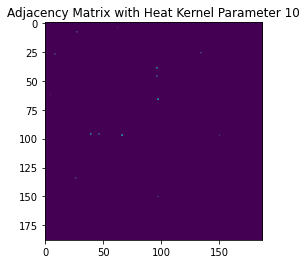

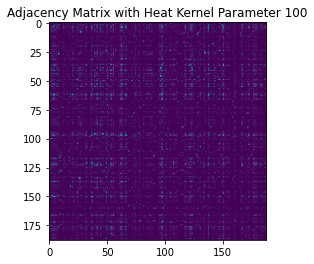

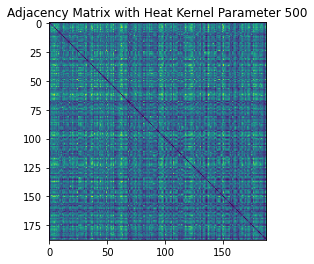

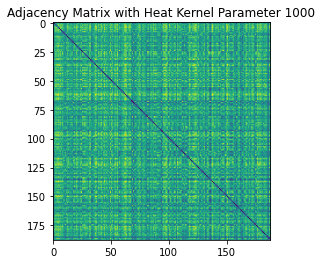

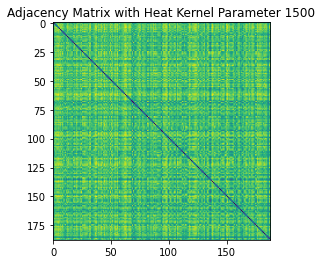

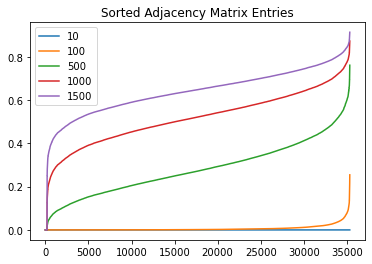

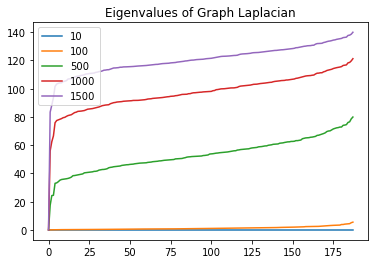

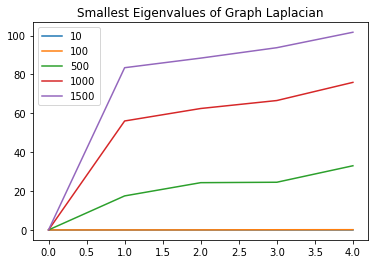

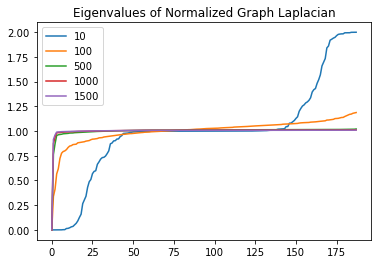

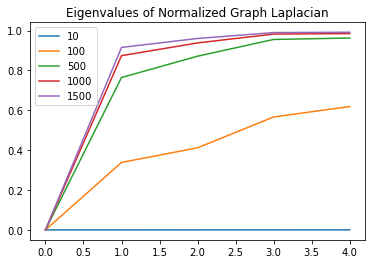

In [16]:
#plots for network with different heat kernel parameters


for hkp in [10, 100, 500, 1000, 1500]:

    A = gt.adjacency_matrix(sorted_X,similarity,h_k_param=hkp)

    plt.figure()
    plt.imshow(A)
    plt.title('Adjacency Matrix with Heat Kernel Parameter ' +str(hkp))

    #laplacian
    incident_edges = np.sum(A,axis = 1)
    #degree matrix
    D = np.diag(incident_edges)*np.eye(m)
    L = D-A

    #calculate the normalized laplacian
    snD = np.diag(1/np.sqrt(incident_edges))*np.eye(m)
    Ln = snD @ (D-A) @ snD

    

    plt.figure('A')
    plt.plot(np.sort(A.flatten()), label = str(hkp))
    plt.legend()
    plt.title('Sorted Adjacency Matrix Entries')

    plt.figure('L')
    plt.plot(np.linalg.eigh(L)[0], label = str(hkp))
    plt.legend()
    plt.title('Eigenvalues of Graph Laplacian')

    plt.figure('L_small')
    plt.plot(np.linalg.eigh(L)[0][:5], label = str(hkp))
    plt.legend()
    plt.title('Smallest Eigenvalues of Graph Laplacian')

    plt.figure('Ln')
    plt.plot(np.linalg.eigh(Ln)[0], label = str(hkp))
    plt.legend()
    plt.title('Eigenvalues of Normalized Graph Laplacian')

    plt.figure('Ln_small')
    plt.plot(np.linalg.eigh(Ln)[0][:5], label = str(hkp))
    plt.legend()
    plt.title('Eigenvalues of Normalized Graph Laplacian')




Text(0.5, 1.0, 'Heat Kernel')

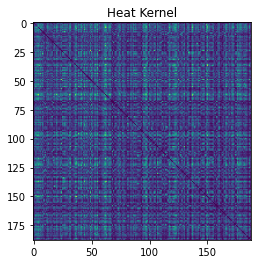

In [17]:
#we choose a heat kernel parameter of 500

A = gt.adjacency_matrix(sorted_X,similarity,h_k_param=300)

plt.figure
plt.imshow(A)
plt.title('Heat Kernel')

91 188


Text(0, 0.5, 'Cluster Sizes')

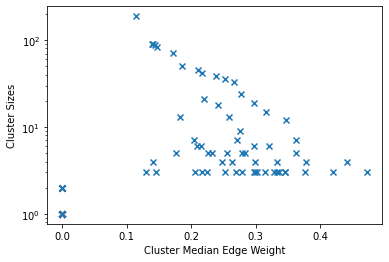

In [18]:
#higherarchical bi-partitioning




nodes = np.arange(m)


clst_adj_hk = []
clst_node_hk = []
all_clusters_node_hk = []

gt.cluster_laplace(A, clst_adj_hk, nodes, 1, clst_node_hk, all_clusters_node_hk, fiedler_switch =not_normalized_laplacian, stop_criteria = 'weight')


count = 0
for c in all_clusters_node_hk:
    if len(c)==1:
        count +=1
print(count, m)


#this gives number of nodes in highest median correlation cluster
n_clusters = len(all_clusters_node_hk)
cluster_scores = np.zeros(n_clusters)
cluster_sizes = np.zeros(n_clusters)
for ii in range(n_clusters):
    cluster = all_clusters_node_hk[ii]
    n_nodes = len(cluster)
    cluster_sizes[ii] = n_nodes
    if n_nodes > 2:
        weights = []
        for i in range(n_nodes):
            for j in range(i+1, n_nodes,1):
                weights.append(A[cluster[i],cluster[j]])
        cluster_scores[ii] = np.median(weights)

len(all_clusters_node_hk[np.argmax(cluster_scores)])

plt.scatter(cluster_scores, cluster_sizes, marker = 'x')
plt.yscale('log')
plt.xlabel('Cluster Median Edge Weight')
plt.ylabel('Cluster Sizes')


In [19]:
#set minimum module size and edge weight
min_module_size = 1
min_cor = .4

idx_scores = np.where(cluster_scores > min_cor)[0]
idx_sizes = np.where(cluster_sizes > min_module_size)[0]
idx = list(set(idx_scores).intersection(set(idx_sizes)))
print('cluster_sizes:')
print([cluster_sizes[i] for i in idx])

modules = []
for i in idx:
    modules.append([[randIDs[j] for j in all_clusters_node_hk[i]], list(all_clusters_node_hk[i])])
print('')
print('cluster elements:')
modules

cluster_sizes:
[3.0, 4.0, 3.0]

cluster elements:


[[['10966', '31915', '7197'], [2, 123, 166]],
 [['10966', '2857', '31915', '7197'], [2, 100, 123, 166]],
 [['26429', '3105', '34279'], [90, 115, 139]]]

In [20]:
#get smallest subset with highest median weights
filtered_modules = []
for module in modules:
    subset = False
    for check_module in modules:
        #flip around to get biggest
        if set(check_module[0]).issubset(set(module[0])) and module[0] != check_module[0]:
            subset = True
    if not subset:
        filtered_modules.append(module)
filtered_modules

[[['10966', '31915', '7197'], [2, 123, 166]],
 [['26429', '3105', '34279'], [90, 115, 139]]]

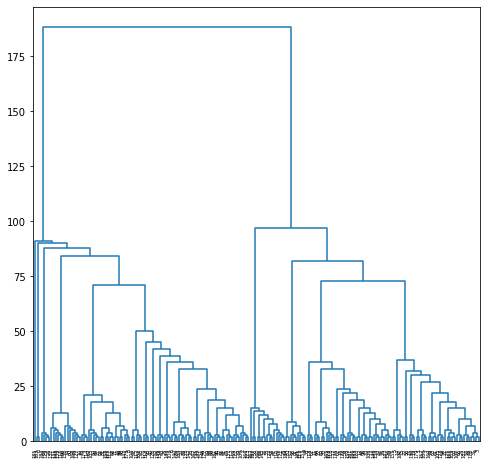

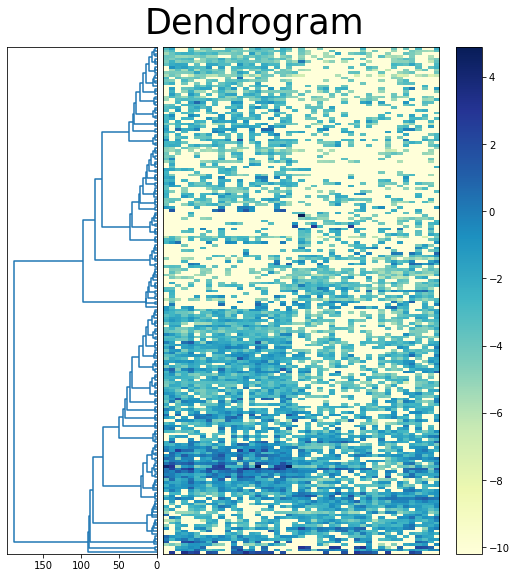

In [21]:


nodes = np.arange(m)


clst_adj_hk = []
clst_node_hk = []
all_clusters_node_hk = []

gt.cluster_laplace(A, clst_adj_hk, nodes, 1, clst_node_hk, all_clusters_node_hk, fiedler_switch =not_normalized_laplacian, stop_criteria = 'size')

#plot dendrograms

for jd in [True, False]:
    gt.plot_dendrogram(all_clusters_node_hk, A, sorted_X, clst_dst = 'dumb', fname = 'delete_me.png', title='Dendrogram', just_dendrogram = jd, split = len(treated_seqID))


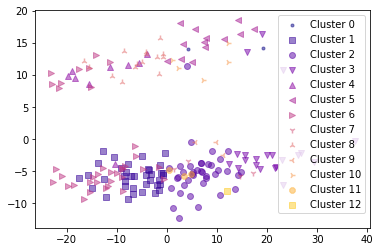

In [22]:
#cut tree to get most distinct clusters
number_clusters = 13


#linkage matrix
Z_hk= gt.linkage_matrix(all_clusters_node_hk, A, 'dumb')

#cut it
labels = gt.cut_tree(Z_hk, n_clusters = number_clusters)

#PCA of genes labeled by cluster
pca = PCA(n_components = 2)
embedding = pca.fit_transform(sorted_X.T)

markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_"]

color_list = plt.get_cmap('plasma').colors

n_colors = len(color_list)

c_sampler = [i*(n_colors//number_clusters) for i in range(number_clusters)]

for i in range(0,number_clusters,1):
    idx = np.where(labels == i)[0]
    plt.scatter(embedding[idx,0],embedding[idx,1], color = color_list[c_sampler[i]], marker = markers[i], label = 'Cluster '+str(i), alpha = .5)

plt.legend()


In [23]:
denovo_pathways = pandas.DataFrame(columns = randIDs, data = np.zeros((13, len(randIDs))))
for i in range(13):
    idx = np.where(labels == i)[0]
    for j in idx:
        denovo_pathways.iloc[i][randIDs[j]] = 1


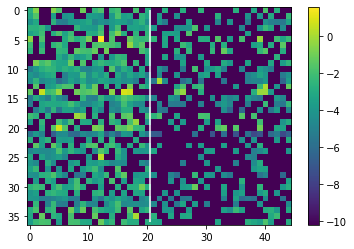

In [24]:
#cluster number 3
idx = np.where(labels == 1)[0]
plt.imshow(sorted_X[:,idx].T)
plt.vlines( len(treated_seqID)-.5, 0,len(idx)-1, color = 'white')
plt.colorbar()

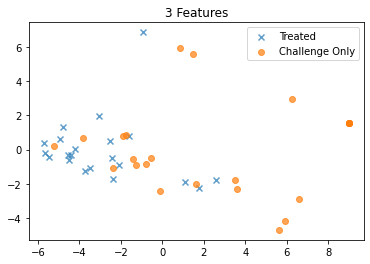

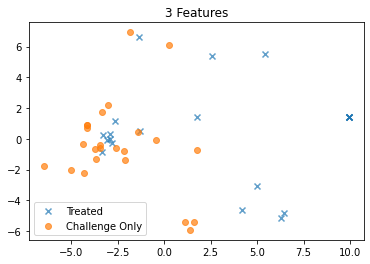

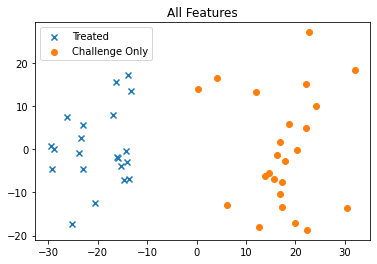

In [25]:
#PCA of subjects using genes in cluster number 1

# idx = np.where(labels == 1)[0]

for ii in range(len(filtered_modules)):
    idx = filtered_modules[ii][1]
    pca = PCA(n_components = 2)
    embedding = pca.fit_transform(sorted_X[:,idx])

    plt.figure()
    idx_none = np.where(np.array(seqID_labels) == 'Treated')
    idx_high = np.where(np.array(seqID_labels) == 'Challenge Only')
    plt.scatter(embedding[idx_none,0], embedding[idx_none,1], label = 'Treated', marker = 'x', alpha = .7)
    plt.scatter(embedding[idx_high,0], embedding[idx_high,1], label = 'Challenge Only', marker = 'o', alpha = .7)
    plt.title(str(len(idx))+ ' Features')
    plt.legend()

pca = PCA(n_components = 2)
embedding = pca.fit_transform(sorted_X)

plt.figure()
plt.title('All Features')
plt.scatter(embedding[idx_none,0], embedding[idx_none,1], label = 'Treated', marker = 'x')
plt.scatter(embedding[idx_high,0], embedding[idx_high,1], label = 'Challenge Only', marker = 'o')
plt.legend()
